# Weights & Biases Demo for Linear Regression

This demo shows how to:
1. Set up W&B experiments
2. Run hyperparameter sweeps
3. Compare loss functions (MAE vs MSE)
4. Analyze weight initialization (Zero vs Random)
5. Create parallel coordinate plots
6. Generate a W&B report

Adapt these concepts for your MLP assignment!

In [1]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
PROJECT_NAME='Linear_regression_demo'

## Create and Visualize Data

In [3]:
def create_synthetic_data(n_samples=1000, n_features=10, noise_level=15, random_seed=42):
    """
    Create synthetic regression data

    Think of this as your MNIST data loading step.
    In your assignment, you'll load MNIST instead of generating synthetic data.
    """
    np.random.seed(random_seed)

    # Generate features (like pixel values in images)
    X = np.random.randn(n_samples, n_features)

    # Create true weights (what we're trying to learn)
    true_weights = np.random.randn(n_features)

    # Generate target variable with some non-linearity
    y = X @ true_weights + 0.3 * (X[:, 0] ** 2) + np.random.randn(n_samples) * noise_level

    return X, y, true_weights

In [4]:

def visualize_data(X, y, save_path=None):
    """
    Visualize the synthetic dataset

    In your assignment, this would be like visualizing MNIST digits
    (Question 2.1 - log sample images from each class)
    """
    fig = plt.figure(figsize=(15, 10))

    # 1. Feature distributions
    ax1 = plt.subplot(2, 3, 1)
    for i in range(min(5, X.shape[1])):
        ax1.hist(X[:, i], bins=30, alpha=0.5, label=f'Feature {i+1}')
    ax1.set_xlabel('Feature Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Feature Distributions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Target distribution
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(y, bins=50, color='green', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Target Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Target Distribution')
    ax2.grid(True, alpha=0.3)

    # 3. Feature correlation with target
    ax3 = plt.subplot(2, 3, 3)
    correlations = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
    ax3.bar(range(len(correlations)), correlations, color='coral', edgecolor='black')
    ax3.set_xlabel('Feature Index')
    ax3.set_ylabel('Correlation with Target')
    ax3.set_title('Feature Importance (Correlation)')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # 4. Scatter plot - Feature 1 vs Target
    ax4 = plt.subplot(2, 3, 4)
    scatter = ax4.scatter(X[:, 0], y, alpha=0.5, c=y, cmap='viridis', s=20)
    ax4.set_xlabel('Feature 1')
    ax4.set_ylabel('Target')
    ax4.set_title('Feature 1 vs Target')
    plt.colorbar(scatter, ax=ax4, label='Target Value')
    ax4.grid(True, alpha=0.3)

    # 5. Feature pairwise relationship
    ax5 = plt.subplot(2, 3, 5)
    scatter2 = ax5.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', alpha=0.6, s=20)
    ax5.set_xlabel('Feature 1')
    ax5.set_ylabel('Feature 2')
    ax5.set_title('Feature 1 vs Feature 2 (colored by target)')
    plt.colorbar(scatter2, ax=ax5, label='Target')
    ax5.grid(True, alpha=0.3)

    # 6. Summary statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    stats_text = f"""
    Dataset Statistics:
    ━━━━━━━━━━━━━━━━━━━━━━━
    Samples: {X.shape[0]}
    Features: {X.shape[1]}

    Target Statistics:
    • Mean: {np.mean(y):.2f}
    • Std: {np.std(y):.2f}
    • Min: {np.min(y):.2f}
    • Max: {np.max(y):.2f}

    Feature Statistics:
    • Mean: {np.mean(X):.3f}
    • Std: {np.std(X):.3f}
    """
    ax6.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center')

    plt.suptitle('Synthetic Data Visualization', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    return fig

## Linear Regression code

In [5]:

class LinearRegression:
    """
    Linear Regression with NumPy

    """

    def __init__(self, n_features, learning_rate=0.01, weight_init='random',
                 weight_decay=0.0):
        self.lr = learning_rate
        self.weight_init = weight_init
        self.weight_decay = weight_decay

        # Initialize weights
        if weight_init == 'zero':
            self.W = np.zeros((n_features, 1))
            self.b = 0.0
        elif weight_init == 'random':
            self.W = np.random.randn(n_features, 1) * 0.01
            self.b = 0.0
        elif weight_init == 'xavier':
            self.W = np.random.randn(n_features, 1) * np.sqrt(2.0 / n_features)
            self.b = 0.0

        # Gradient storage (required for autograder verification)
        self.grad_W = None
        self.grad_b = None

    def forward(self, X):
        """Forward pass"""
        return X @ self.W + self.b

    def compute_loss(self, y_true, y_pred, loss_type='mse'):
        """
        Compute loss based on type

        """
        if loss_type == 'mse':
            loss = np.mean((y_true - y_pred) ** 2)
        elif loss_type == 'mae':
            loss = np.mean(np.abs(y_true - y_pred))
        else:
            raise ValueError(f"Unknown loss: {loss_type}")

        # Add L2 regularization
        if self.weight_decay > 0:
            l2_penalty = 0.5 * self.weight_decay * np.sum(self.W ** 2)
            loss += l2_penalty

        return loss

    def backward(self, X, y_true, y_pred, loss_type='mse'):
        """
        Compute gradients

        """
        m = X.shape[0]

        if loss_type == 'mse':
            error = y_pred - y_true
        elif loss_type == 'mae':
            error = np.sign(y_pred - y_true)

        # Compute gradients
        self.grad_W = (X.T @ error) / m
        self.grad_b = np.mean(error)

        # Add L2 regularization gradient
        if self.weight_decay > 0:
            self.grad_W += self.weight_decay * self.W

        return self.grad_W, self.grad_b

    def update_weights(self):
        """Update weights using gradient descent"""
        self.W -= self.lr * self.grad_W
        self.b -= self.lr * self.grad_b

    def predict(self, X):
        """Make predictions"""
        return self.forward(X)

## Training

In [11]:
def train_with_wandb(config=None, exp_name='base'):
    """
    Complete training loop with W&B logging

    """

    #================KEY STEP====================
    wandb.init(project=PROJECT_NAME, name=exp_name)

    print("Generating synthetic data...")
    X, y, true_weights = create_synthetic_data(
            n_samples=1000,
            n_features=10,
            noise_level=15
    )
    y = y.reshape(-1, 1)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Initialize model
    model = LinearRegression(
            n_features=X_train.shape[1],
            learning_rate=config["learning_rate"],
            weight_init=config["weight_init"])

    # Training metrics storage
    train_losses = []
    val_losses = []
    gradient_norms = []
    weight_norms = []

    print(f"\n{'='*60}")
    print(f"Training Configuration:")
    print(f"  Loss: {config["loss_type"]}")
    print(f"  Init: {config["weight_init"]}")
    print(f"  LR: {config["learning_rate"]}")
    print(f"  Epochs: {config["epochs"]}")
    print(f"{'='*60}\n")

    # Training loop
    for epoch in range(config["epochs"]):
        # Forward pass
        y_pred_train = model.forward(X_train)
        train_loss = model.compute_loss(y_train, y_pred_train, config["loss_type"])

        # Backward pass
        model.backward(X_train, y_train, y_pred_train, config["loss_type"])

        # Track metrics
        grad_norm = np.linalg.norm(model.grad_W)
        weight_norm = np.linalg.norm(model.W)

        gradient_norms.append(grad_norm)
        weight_norms.append(weight_norm)

        # Update weights
        model.update_weights()

        # Validation
        y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(y_val, y_pred_val, config["loss_type"])

        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate R² score (for regression evaluation)
        ss_res = np.sum((y_val - y_pred_val) ** 2)
        ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
        r2_score = 1 - (ss_res / ss_tot)

        # === KEY STEP: LOG TO W&B ===
        wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'gradient_norm': grad_norm,
                'weight_norm': weight_norm,
                'r2_score': r2_score,
                'overfitting_gap': train_loss - val_loss,})

        # Print progress
        if epoch % 20 == 0 or epoch == config["epochs"] - 1:
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, "
                      f"Val Loss = {val_loss:.4f}, R² = {r2_score:.4f}")

    # === LOG FINAL METRICS ===
    final_metrics = {
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'final_r2': r2_score,
            'best_val_loss': min(val_losses),
            'convergence_epoch': np.argmin(val_losses),
        }
    wandb.log(final_metrics)


    # === LOG PREDICTION SCATTER PLOT ===
    # pred_fig = create_prediction_plot(y_val, y_pred_val)
    # wandb.log({"predictions": wandb.Image(pred_fig)})
    # plt.close(pred_fig)

    wandb.finish()
    print(f"\n✓ Training completed!")
    print(f"  Final Val Loss: {val_losses[-1]:.4f}")
    print(f"  Final R²: {r2_score:.4f}")

    return val_losses[-1]

## DEMO 1: Basic W&B Logging (Single Run)

In [7]:
def data_visualization():
    """
    DEMO 1: Visualize the synthetic data
    This is like Question 2.1 in your assignment
    """
    print("\n" + "="*70)
    print("DEMO 1: Data Visualization")
    print("="*70)

    # Generate data
    X, y, true_weights = create_synthetic_data()

    # Create visualization
    fig = visualize_data(X, y)

    # Log to W&B
    #=========KEY STEP=================
    wandb.init(project=PROJECT_NAME, name="data_viz")

    wandb.log({
        "data_visualization": wandb.Image(fig),
        "n_samples": X.shape[0],
        "n_features": X.shape[1]
    })

    # Also create a W&B table
    table = wandb.Table(columns=["Sample ID", "Feature 1", "Feature 2", "Target"])
    for i in range(20):  # Show first 20 samples
        table.add_data(i, X[i, 0], X[i, 1], y[i])

    wandb.log({"sample_data": table})

    plt.savefig('/tmp/data_viz.png', dpi=150, bbox_inches='tight')
    plt.show()

    wandb.finish()

    print("\n✓ Data visualization logged to W&B!")
    print("  Check your dashboard for the visualization and data table")




DEMO 1: Data Visualization


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: da24s004 (da24s004-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


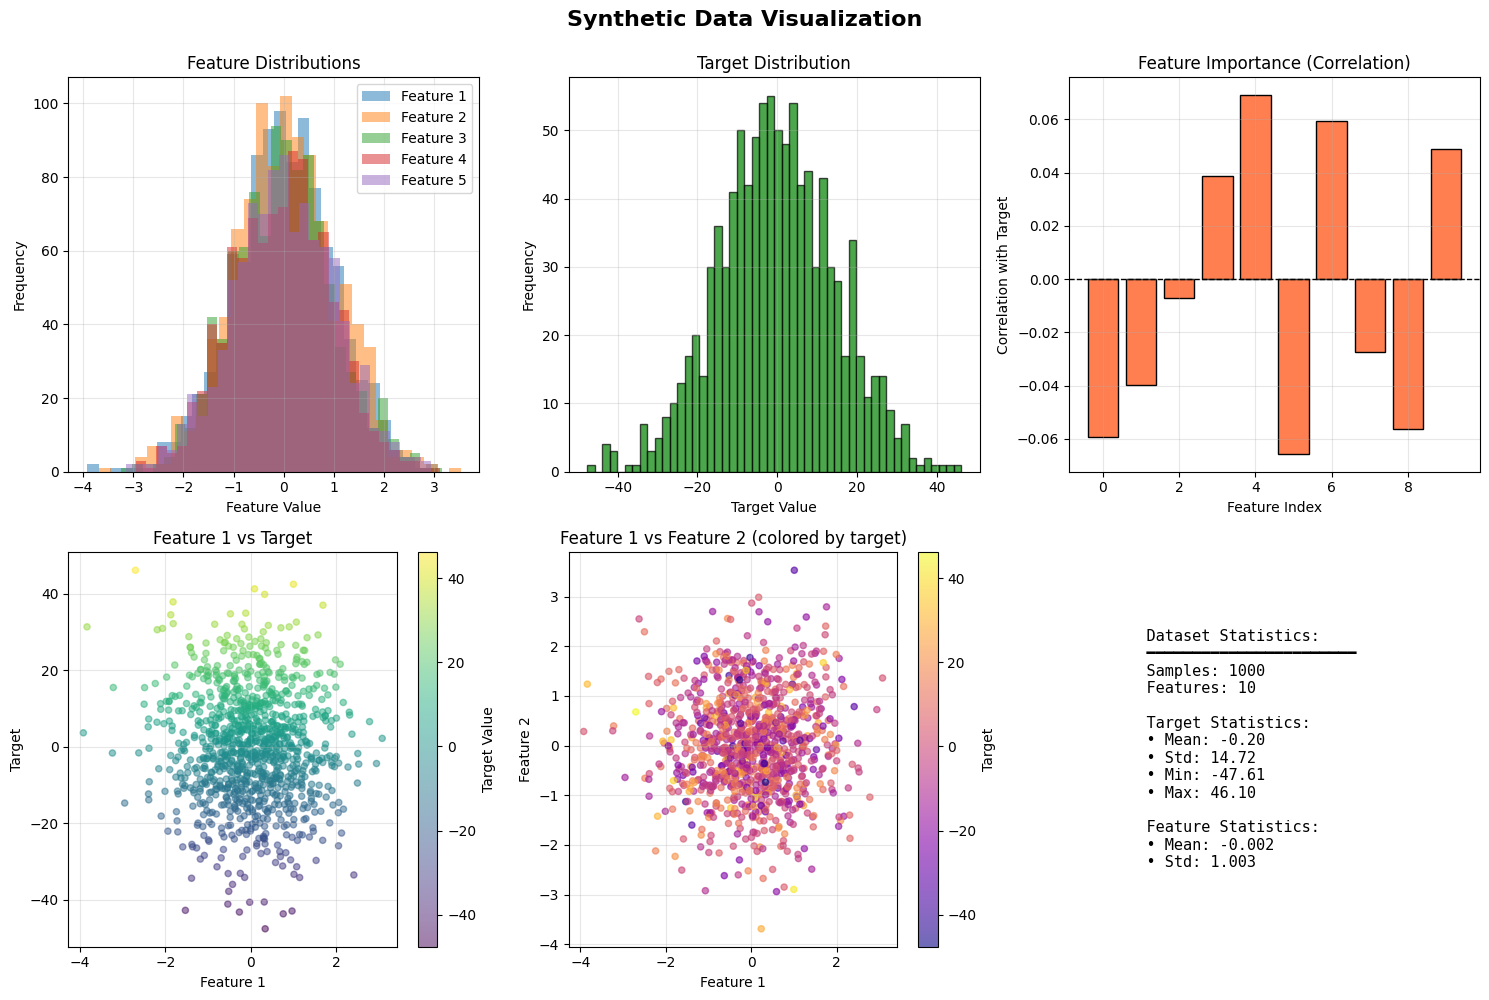

n_features,▁
n_samples,▁
n_features,10
n_samples,1000



✓ Data visualization logged to W&B!
  Check your dashboard for the visualization and data table


In [8]:
data_visualization()

## Demo 2: Training with wandb logging

In [9]:
def training():
    """
    DEMO 2: Train a single model with W&B logging
    """
    print("\n" + "="*70)
    print("DEMO 2: Single Training Run")
    print("="*70)

    config = {
        'learning_rate': 0.001,
        'epochs': 100,
        'loss_type': 'mse',
        'weight_init': 'random'
    }

    train_with_wandb(config, exp_name='initial_training with new lr')

    print("\n✓ Training completed and logged to W&B!")

In [10]:
training()


DEMO 2: Single Training Run


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: random
  LR: 0.001
  Epochs: 100

Epoch   0: Train Loss = 217.0877, Val Loss = 214.9517, R² = -0.0102
Epoch  20: Train Loss = 216.8975, Val Loss = 214.7864, R² = -0.0095
Epoch  40: Train Loss = 216.7148, Val Loss = 214.6278, R² = -0.0087
Epoch  60: Train Loss = 216.5392, Val Loss = 214.4756, R² = -0.0080
Epoch  80: Train Loss = 216.3706, Val Loss = 214.3296, R² = -0.0073
Epoch  99: Train Loss = 216.2165, Val Loss = 214.1965, R² = -0.0067

✓ Training completed!
  Final Val Loss: 214.1965
  Final R²: -0.0067

✓ Training completed and logged to W&B!


## Demo 3: Loss and init Comparison

In [12]:
def loss_comparison():
    """
    DEMO 3: Compare MSE vs MAE loss functions
    This is like Question 2.6 in your assignment (MSE vs Cross-Entropy)
    """
    print("\n" + "="*70)
    print("DEMO 3: Loss Function Comparison (MSE vs MAE)")
    print("="*70)

    configs = [
        {'learning_rate': 0.01, 'epochs': 100, 'loss_type': 'mse','weight_init': 'random'},
        {'learning_rate': 0.01, 'epochs': 100, 'loss_type': 'mae', 'weight_init': 'random'},
    ]

    for cfg in configs:
        print(f"\nTraining with {cfg['loss_type'].upper()} loss...")
        train_with_wandb(cfg, exp_name=f"loss_comparison_with_{cfg['loss_type'].upper()}")

    print("\n✓ Loss comparison completed!")
    print("  Go to W&B dashboard and compare the two runs side-by-side")
    print("  Key question: Which loss converged faster?")

In [13]:
loss_comparison()


DEMO 3: Loss Function Comparison (MSE vs MAE)

Training with MSE loss...


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,████▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
overfitting_gap,█████▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
r2_score,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██
train_loss,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
+2,...


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: random
  LR: 0.01
  Epochs: 100

Epoch   0: Train Loss = 217.0877, Val Loss = 214.8761, R² = -0.0099
Epoch  20: Train Loss = 215.4829, Val Loss = 213.5156, R² = -0.0035
Epoch  40: Train Loss = 214.4087, Val Loss = 212.6207, R² = 0.0007
Epoch  60: Train Loss = 213.6889, Val Loss = 212.0349, R² = 0.0035
Epoch  80: Train Loss = 213.2061, Val Loss = 211.6539, R² = 0.0053
Epoch  99: Train Loss = 212.8951, Val Loss = 211.4181, R² = 0.0064


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,████▇▇▇▇▆▆▆▆▆▆▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁
overfitting_gap,█▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
r2_score,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,██▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
+2,...



✓ Training completed!
  Final Val Loss: 211.4181
  Final R²: 0.0064

Training with MAE loss...


Generating synthetic data...

Training Configuration:
  Loss: mae
  Init: random
  LR: 0.01
  Epochs: 100

Epoch   0: Train Loss = 11.6869, Val Loss = 11.6999, R² = -0.0103
Epoch  20: Train Loss = 11.6831, Val Loss = 11.6977, R² = -0.0097
Epoch  40: Train Loss = 11.6795, Val Loss = 11.6955, R² = -0.0092
Epoch  60: Train Loss = 11.6760, Val Loss = 11.6935, R² = -0.0088
Epoch  80: Train Loss = 11.6727, Val Loss = 11.6914, R² = -0.0083
Epoch  99: Train Loss = 11.6695, Val Loss = 11.6895, R² = -0.0079


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,████▆▆▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
overfitting_gap,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
r2_score,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,█████▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
+2,...



✓ Training completed!
  Final Val Loss: 11.6895
  Final R²: -0.0079

✓ Loss comparison completed!
  Go to W&B dashboard and compare the two runs side-by-side
  Key question: Which loss converged faster?


In [14]:
def weight_init_comparison():
    """
Compare Zero vs Random initialization
    """
    print("\n" + "="*70)
    print(" Weight Initialization Comparison")
    print("="*70)

    configs = [
        {'learning_rate': 0.01, 'epochs': 100, 'loss_type': 'mse','weight_init': 'zero'},
        {'learning_rate': 0.01, 'epochs': 100, 'loss_type': 'mse','weight_init': 'random'}

    ]

    for cfg in configs:
        print(f"\nTraining with {cfg['weight_init']} initialization...")
        train_with_wandb(cfg, exp_name=f"comparing_weight_init_with_{cfg['weight_init']}")

    print("\n✓ Weight initialization comparison completed!")
    print("  Compare gradient norms across the three runs")
    print("  Zero init should show slower/different convergence")

In [15]:
weight_init_comparison()


DEMO 4: Weight Initialization Comparison

Training with zero initialization...


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: zero
  LR: 0.01
  Epochs: 100

Epoch   0: Train Loss = 217.1056, Val Loss = 215.0553, R² = -0.0107
Epoch  20: Train Loss = 215.4954, Val Loss = 213.6601, R² = -0.0042
Epoch  40: Train Loss = 214.4174, Val Loss = 212.7376, R² = 0.0002
Epoch  60: Train Loss = 213.6950, Val Loss = 212.1297, R² = 0.0030
Epoch  80: Train Loss = 213.2102, Val Loss = 211.7309, R² = 0.0049
Epoch  99: Train Loss = 212.8981, Val Loss = 211.4815, R² = 0.0061


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
overfitting_gap,███▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
r2_score,▁▁▁▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+2,...



✓ Training completed!
  Final Val Loss: 211.4815
  Final R²: 0.0061

Training with random initialization...


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: random
  LR: 0.01
  Epochs: 100

Epoch   0: Train Loss = 217.0877, Val Loss = 214.8761, R² = -0.0099
Epoch  20: Train Loss = 215.4829, Val Loss = 213.5156, R² = -0.0035
Epoch  40: Train Loss = 214.4087, Val Loss = 212.6207, R² = 0.0007
Epoch  60: Train Loss = 213.6889, Val Loss = 212.0349, R² = 0.0035
Epoch  80: Train Loss = 213.2061, Val Loss = 211.6539, R² = 0.0053
Epoch  99: Train Loss = 212.8951, Val Loss = 211.4181, R² = 0.0064


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
overfitting_gap,██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
r2_score,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████████
train_loss,████▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
+2,...



✓ Training completed!
  Final Val Loss: 211.4181
  Final R²: 0.0064

✓ Weight initialization comparison completed!
  Compare gradient norms across the three runs
  Zero init should show slower/different convergence


## Demo 4: Hyperparameter Sweep

In [16]:
def train_with_wandb_for_sweep(config=None):
    """Training function for sweeps or manual configs"""

    #=============KEY STEP=======================
    # ONE init call with 'with' statement
    with wandb.init(project=PROJECT_NAME, config=config):
        # Access config
        cfg = wandb.config

        # Generate data
        print("Generating synthetic data...")
        X, y, true_weights = create_synthetic_data(
            n_samples=1000,
            n_features=10,
            noise_level=15
        )
        y = y.reshape(-1, 1)

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Normalize features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Initialize model
        model = LinearRegression(
            n_features=X_train.shape[1],
            learning_rate=cfg.learning_rate,
            weight_init=cfg.weight_init
        )

        # Training metrics storage
        train_losses = []
        val_losses = []
        gradient_norms = []
        weight_norms = []

        print(f"\n{'='*60}")
        print(f"Training Configuration:")
        print(f"  Loss: {cfg.loss_type}")
        print(f"  Init: {cfg.weight_init}")
        print(f"  LR: {cfg.learning_rate}")
        print(f"  Epochs: {cfg.epochs}")
        print(f"{'='*60}\n")

        # Training loop
        for epoch in range(cfg.epochs):
            # Forward pass
            y_pred_train = model.forward(X_train)
            train_loss = model.compute_loss(y_train, y_pred_train, cfg.loss_type)

            # Backward pass
            model.backward(X_train, y_train, y_pred_train, cfg.loss_type)

            # Track metrics
            grad_norm = np.linalg.norm(model.grad_W)
            weight_norm = np.linalg.norm(model.W)

            gradient_norms.append(grad_norm)
            weight_norms.append(weight_norm)

            # Update weights
            model.update_weights()

            # Validation
            y_pred_val = model.forward(X_val)
            val_loss = model.compute_loss(y_val, y_pred_val, cfg.loss_type)

            # Store losses
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Calculate R² score
            ss_res = np.sum((y_val - y_pred_val) ** 2)
            ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
            r2_score = 1 - (ss_res / ss_tot)

            # === LOG TO W&B ===
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'gradient_norm': grad_norm,
                'weight_norm': weight_norm,
                'r2_score': r2_score,
                'overfitting_gap': train_loss - val_loss,
            })

            # Print progress
            if epoch % 20 == 0 or epoch == cfg.epochs - 1:
                print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, "
                      f"Val Loss = {val_loss:.4f}, R² = {r2_score:.4f}")

        # === LOG FINAL METRICS ===
        final_metrics = {
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'final_r2': r2_score,
            'best_val_loss': min(val_losses),
            'convergence_epoch': np.argmin(val_losses),
        }
        wandb.log(final_metrics)



        # pred_fig = create_prediction_plot(y_val, y_pred_val)
        # wandb.log({"predictions": wandb.Image(pred_fig)})
        # plt.close(pred_fig)

        print(f"\n✓ Training completed!")
        print(f"  Final Val Loss: {val_losses[-1]:.4f}")
        print(f"  Final R²: {r2_score:.4f}")

        return val_losses[-1]

In [17]:
wandb.finish()

# Define sweep configuration
sweep_config = {
    'method': 'grid',
    'metric': {'name': 'final_test_loss', 'goal': 'minimize'},
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.05]  # ✅ Only 2 values
        },
        'loss_type': {
            'values': ['mse', 'mae']  # 2 values
        },
        'weight_init': {
            'values': ['random', 'xavier']  # 2 values
        },
        'epochs': {'value': 50}  # ✅ Shorter epochs
    }
}

#================KEY STEP===================
print("Creating sweep...")
sweep_id = wandb.sweep(
    sweep_config,
    project=PROJECT_NAME
)

# Calculate total runs
total_runs = 2 * 2 * 2
print(f"✓ Sweep created: {sweep_id}")
print(f"  Grid search will run {total_runs} experiments")
print("  Starting sweep...")

# Run sweep
wandb.agent(sweep_id, train_with_wandb_for_sweep, count=total_runs)

print("\n✓ Sweep completed!")
print("  Check your W&B dashboard!")

Creating sweep...
Create sweep with ID: oy2wwwug
Sweep URL: https://wandb.ai/da24s004-iitm/Linear_regression_demo/sweeps/oy2wwwug
✓ Sweep created: oy2wwwug
  Grid search will run 8 experiments
  Starting sweep...


wandb: Agent Starting Run: hvzvb01h with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	loss_type: mse
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: random
  LR: 0.01
  Epochs: 50

Epoch   0: Train Loss = 217.0877, Val Loss = 214.8761, R² = -0.0099
Epoch  20: Train Loss = 215.4829, Val Loss = 213.5156, R² = -0.0035
Epoch  40: Train Loss = 214.4087, Val Loss = 212.6207, R² = 0.0007
Epoch  49: Train Loss = 214.0491, Val Loss = 212.3261, R² = 0.0021

✓ Training completed!
  Final Val Loss: 212.3261
  Final R²: 0.0021


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
overfitting_gap,███▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
r2_score,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
+2,...


wandb: Agent Starting Run: vdqk0gwy with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	loss_type: mse
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: xavier
  LR: 0.01
  Epochs: 50

Epoch   0: Train Loss = 217.3774, Val Loss = 208.3544, R² = 0.0208
Epoch  20: Train Loss = 215.6600, Val Loss = 208.0900, R² = 0.0220
Epoch  40: Train Loss = 214.5174, Val Loss = 208.1177, R² = 0.0219
Epoch  49: Train Loss = 214.1365, Val Loss = 208.1879, R² = 0.0215

✓ Training completed!
  Final Val Loss: 208.1879
  Final R²: 0.0215


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
overfitting_gap,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
r2_score,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇████████████▇▇▇▇▇▇▆▆▆▆▅
train_loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
+2,...


wandb: Agent Starting Run: 404d1lpm with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	loss_type: mae
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mae
  Init: random
  LR: 0.01
  Epochs: 50

Epoch   0: Train Loss = 11.6869, Val Loss = 11.6999, R² = -0.0103
Epoch  20: Train Loss = 11.6831, Val Loss = 11.6977, R² = -0.0097
Epoch  40: Train Loss = 11.6795, Val Loss = 11.6955, R² = -0.0092
Epoch  49: Train Loss = 11.6779, Val Loss = 11.6946, R² = -0.0090

✓ Training completed!
  Final Val Loss: 11.6946
  Final R²: -0.0090


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██████████▆▆▆▆▆▆▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▁
overfitting_gap,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
r2_score,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
+2,...


wandb: Agent Starting Run: 5vc2wmug with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	loss_type: mae
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mae
  Init: xavier
  LR: 0.01
  Epochs: 50

Epoch   0: Train Loss = 11.6956, Val Loss = 11.6130, R² = 0.0207
Epoch  20: Train Loss = 11.6919, Val Loss = 11.6118, R² = 0.0208
Epoch  40: Train Loss = 11.6883, Val Loss = 11.6108, R² = 0.0209
Epoch  49: Train Loss = 11.6867, Val Loss = 11.6103, R² = 0.0210

✓ Training completed!
  Final Val Loss: 11.6103
  Final R²: 0.0210


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁
overfitting_gap,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
r2_score,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
+2,...


wandb: Agent Starting Run: x3msxuz9 with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.05
wandb: 	loss_type: mse
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: random
  LR: 0.05
  Epochs: 50

Epoch   0: Train Loss = 217.0877, Val Loss = 214.5489, R² = -0.0083
Epoch  20: Train Loss = 212.8553, Val Loss = 211.3520, R² = 0.0067
Epoch  40: Train Loss = 212.2993, Val Loss = 211.0384, R² = 0.0082
Epoch  49: Train Loss = 212.2478, Val Loss = 211.0340, R² = 0.0082

✓ Training completed!
  Final Val Loss: 211.0340
  Final R²: 0.0082


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██▇▇▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
overfitting_gap,█▇▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
r2_score,▁▂▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇██████████████████████
train_loss,█▇▆▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...


wandb: Agent Starting Run: ek1h4gtp with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.05
wandb: 	loss_type: mse
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mse
  Init: xavier
  LR: 0.05
  Epochs: 50

Epoch   0: Train Loss = 217.3774, Val Loss = 208.2674, R² = 0.0212
Epoch  20: Train Loss = 212.8801, Val Loss = 208.9452, R² = 0.0180
Epoch  40: Train Loss = 212.3020, Val Loss = 210.1331, R² = 0.0124
Epoch  49: Train Loss = 212.2489, Val Loss = 210.4513, R² = 0.0109

✓ Training completed!
  Final Val Loss: 210.4513
  Final R²: 0.0109


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,██▇▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
overfitting_gap,██▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
r2_score,▇████████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▇▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...


wandb: Agent Starting Run: r79y2s6t with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.05
wandb: 	loss_type: mae
wandb: 	weight_init: random
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mae
  Init: random
  LR: 0.05
  Epochs: 50

Epoch   0: Train Loss = 11.6869, Val Loss = 11.6994, R² = -0.0102
Epoch  20: Train Loss = 11.6693, Val Loss = 11.6890, R² = -0.0078
Epoch  40: Train Loss = 11.6550, Val Loss = 11.6795, R² = -0.0058
Epoch  49: Train Loss = 11.6492, Val Loss = 11.6754, R² = -0.0050

✓ Training completed!
  Final Val Loss: 11.6754
  Final R²: -0.0050


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,███▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
overfitting_gap,███▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
r2_score,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
+2,...


wandb: Agent Starting Run: sl1qmihk with config:
wandb: 	epochs: 50
wandb: 	learning_rate: 0.05
wandb: 	loss_type: mae
wandb: 	weight_init: xavier
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Generating synthetic data...

Training Configuration:
  Loss: mae
  Init: xavier
  LR: 0.05
  Epochs: 50

Epoch   0: Train Loss = 11.6956, Val Loss = 11.6127, R² = 0.0207
Epoch  20: Train Loss = 11.6788, Val Loss = 11.6077, R² = 0.0212
Epoch  40: Train Loss = 11.6638, Val Loss = 11.6032, R² = 0.0213
Epoch  49: Train Loss = 11.6574, Val Loss = 11.6015, R² = 0.0213

✓ Training completed!
  Final Val Loss: 11.6015
  Final R²: 0.0213


best_val_loss,▁
convergence_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_r2,▁
final_train_loss,▁
final_val_loss,▁
gradient_norm,███▇▇▇▇▇▇▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
overfitting_gap,██▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
r2_score,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train_loss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
+2,...



✓ Sweep completed!
  Check your W&B dashboard!


## Lets Create the Wandb Report!!